> Описание задания

А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

 

Описание колонок
experimentVariant – вариант эксперимента
version – версия приложения
purchase – факт покупки
 

Задача
Запустите A/A-тест
Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.
Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)
Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
df

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...,...
127013,127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127014,127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127015,127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127016,127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


In [3]:
df['purchase'].sort_values(ascending=False)

93352    1
86558    1
70130    1
70129    1
25374    1
        ..
83814    0
83815    0
83816    0
83817    0
0        0
Name: purchase, Length: 127018, dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127018 entries, 0 to 127017
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Unnamed: 0         127018 non-null  int64 
 1   uid                127018 non-null  object
 2   experimentVariant  127018 non-null  int64 
 3   version            127018 non-null  object
 4   purchase           127018 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 4.8+ MB


In [5]:
s1_var = df[df['experimentVariant']==1]['purchase']
s2_var = df[df['experimentVariant']==0]['purchase']

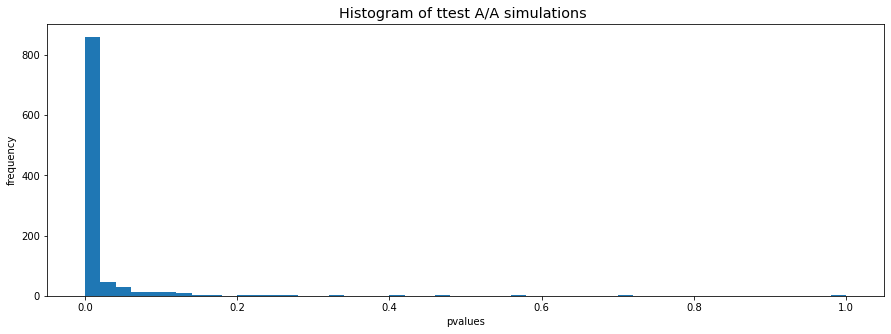

0.923

In [6]:
n = 100000
simulations = 1000
n_s = 1000
res = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = s1_var.sample(n_s, replace = False).values
    s2 = s2_var.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

    
plt.figure(figsize=(15,5))    
plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

A/A-тест не сходится

In [7]:
df.groupby(['experimentVariant', 'version'], as_index=False)\
            .agg({'purchase':'count'}) # проверю количество наблюдений в выборках

,experimentVariant,version,purchase
0,0,v2.8.0,41283
1,0,v2.9.0,11921
2,0,v3.7.4.0,4204
3,0,v3.8.0.0,5694
4,1,v2.8.0,41552
5,1,v2.9.0,12033
6,1,v3.7.4.0,4221
7,1,v3.8.0.0,6110


In [8]:
df.groupby(['experimentVariant', 'version'], as_index=False).agg({'purchase':'mean'})

,experimentVariant,version,purchase
0,0,v2.8.0,0.000993
1,0,v2.9.0,0.074658
2,0,v3.7.4.0,0.059943
3,0,v3.8.0.0,0.057604
4,1,v2.8.0,0.045606
5,1,v2.9.0,0.071304
6,1,v3.7.4.0,0.063018
7,1,v3.8.0.0,0.062848


Для группы "0" и version v2.8.0 конверсия покупки значительно отличается от остальных. Вероятно проблема именно в ней. Но для уточнения проведу сравнение между группами по каждой версии отдельно.

Считаю p-value для каждой "version" с помощью Манна_Уитни

In [9]:
df['version'].unique()

array(['v2.8.0', 'v2.9.0', 'v3.7.4.0', 'v3.8.0.0'], dtype=object)

In [10]:
df_v280=df.query("version=='v2.8.0'")
v280_1 = df_v280[df_v280['experimentVariant']==1]['purchase']
v280_2 = df_v280[df_v280['experimentVariant']==0]['purchase']

In [11]:
df_v290=df.query("version=='v2.9.0'")
v290_1 = df_v290[df_v290['experimentVariant']==1]['purchase']
v290_2 = df_v290[df_v290['experimentVariant']==0]['purchase']

In [12]:
df_v3740=df.query("version=='v3.7.4.0'")
v3740_1 = df_v3740[df_v3740['experimentVariant']==1]['purchase']
v3740_2 = df_v3740[df_v3740['experimentVariant']==0]['purchase']

In [13]:
df_v3800=df.query("version=='v3.8.0.0'")
v3800_1 = df_v3800[df_v3800['experimentVariant']==1]['purchase']
v3800_2 = df_v3800[df_v3800['experimentVariant']==0]['purchase']

In [14]:
res=stats.mannwhitneyu (v280_1,v280_2)
print('p-value:', res[1])

p-value: 0.0


In [15]:
res=stats.mannwhitneyu (v290_1,v290_2)
print('p-value:', res[1])

p-value: 0.31829983470708123


In [16]:
res=stats.mannwhitneyu (v3740_1,v3740_2)
print('p-value:', res[1])

p-value: 0.5568648248217467


In [17]:
res=stats.mannwhitneyu (v3800_1,v3800_2)
print('p-value:', res[1])

p-value: 0.23185636638957852


Как и предполагалось изначально, проблема в версии 'v2.8.0'. По остальным p-value>0.05. Уберу v2.8.0 из выборки и запущу А/А без этой версии

In [18]:
df1=df.query("version!='v2.8.0'")

In [19]:
b1_var = df1[df1['experimentVariant']==1]['purchase']
b2_var = df1[df1['experimentVariant']==0]['purchase']

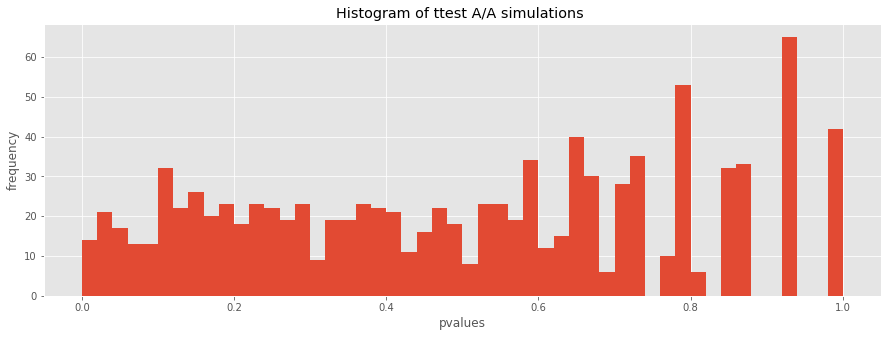

0.045

In [20]:
n = 100000
simulations = 1000
n_s = 1000
res = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    b1 = b1_var.sample(n_s, replace = False).values
    b2 = b2_var.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(b1, b2, equal_var = False)[1]) # сохраняем pvalue

    
plt.figure(figsize=(15,5))    
plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

теперь корректно